In [82]:
import os 
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
from langchain_anthropic import ChatAnthropic
os.getenv("GROQ_API_KEY")
os.getenv("TAVILY_API_KEY")
os.getenv("ANTHROPIC_API_KEY")
groq_llm=ChatGroq(model="llama-3.1-70b-versatile")
# groq_llm=ChatGroq(model="Mixtral-8x7b-32768")

search = TavilySearchResults()

In [83]:
user_query=input("Enter your query: ")

In [84]:
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_API_KEY="<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>"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_PROJECT="Rag Agent Langgraph"
"<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>"

'<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>'

In [85]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel , Field
from langchain_core.prompts import PromptTemplate , ChatPromptTemplate , SystemMessagePromptTemplate , HumanMessagePromptTemplate 
from langchain.output_parsers import PydanticOutputParser 

class RouteQuery(BaseModel):
    """Route the user query to most relevant datasource"""
    Tool_To_Use:str=Field(description="Which datasouce to choose from this VectoreStore OR Websearch according to user prompt , Give only the name VectoreStore or Websearch nothing else")
    # datasouce:Literal["vector_store" , "web_seacrh"]=Field(description="Given a user query route it to either vector store or web search")

parser=PydanticOutputParser(pydantic_object=RouteQuery)


In [86]:

class RouteQuery(BaseModel):
    """Route the user query to most relevant datasource"""
    Tool_To_Use:str=Field(description="Which datasouce to choose from this VectoreStore OR Websearch according to user prompt , Give only the name VectoreStore or Websearch nothing else")
    # datasouce:Literal["vector_store" , "web_seacrh"]=Field(description="Given a user query route it to either vector store or web search")

parser=PydanticOutputParser(pydantic_object=RouteQuery)

def router_function(user_query:str)->str:
    """
    This is a router function that routes the user query to the best datasouce
    """
    
    system_prompt="""You are a expert sytem router that analyzes the user query and then will check the best datasource to get the relevant information for the user query \n
    The vectore store contains information about our clothing brand zilbil it contains 'Refund Policy' , 'Discounts and Promotions' , 'Processing Time' , 'Information Collection' , 'How do I track my order?' , 'Contact Us Information'. Use Vector Store to answer these kind of user queries and for all other use Web Search"""
    human_prompt="{input} \n {formatted_output}"

    data_source_prompt_template=ChatPromptTemplate.from_messages([SystemMessagePromptTemplate.from_template(system_prompt) , HumanMessagePromptTemplate.from_template(human_prompt) , ("placeholder" , "{agent_scratchpad}")])


    formatted_prompt=data_source_prompt_template.format_messages(input=user_query , formatted_output=parser.get_format_instructions())

    Data_source_response=groq_llm.invoke(formatted_prompt)
    json_output = Data_source_response.content.replace("\\", "")
    router_response=parser.parse(json_output)
    return router_response



In [87]:
user_question="What do you know about mercedes gls"
router_finals=router_function(user_question)

In [88]:
print(router_finals.Tool_To_Use)

Websearch


In [89]:
# router_response=parser.parse(json_output)
# print(router_response)

In [90]:
from langchain.chains import RetrievalQA
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough



In [91]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import RetrievalQA
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from pprint import pprint

import os

search = TavilySearchResults()

def index_exists(folder_path):
    return os.path.exists(folder_path) and os.path.isfile(os.path.join(folder_path, "index.faiss"))

# Define the path to your db_index folder
db_index_path = "./db_index"

# Define embedding model
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)

# Check if the index exists
if index_exists(db_index_path):
    print("Loading existing vector store from db_index...")
    vectordb = FAISS.load_local(db_index_path, embeddings=hf, allow_dangerous_deserialization=True)
else:
    print("Creating new vector store...")
    directory_path = "./documents"
    text_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]

    if text_files:
        all_chunks = []
        for text_file in text_files:
            file_path = os.path.join(directory_path, text_file)
            loader = TextLoader(file_path)
            documents = loader.load()
            
            for doc in documents:
                text = doc.page_content
                splitter = CharacterTextSplitter(separator="\n", chunk_size=1000, chunk_overlap=200)
                chunks = splitter.split_text(text)
                
                for chunk in chunks:
                    chunk_doc = Document(page_content=chunk)
                    all_chunks.append(chunk_doc)

        chunk_texts = [doc.page_content for doc in all_chunks]
        
        # Create FAISS vector store
        vectordb = FAISS.from_texts(chunk_texts, embedding=hf)
        
        # Save the vector store
        print("Saving new vector store to db_index...")
        vectordb.save_local(db_index_path)
    else:
        print("No text files found in the documents directory.")
        raise ValueError("No documents to process")

# Set up the retriever
retriever = vectordb.as_retriever(search_kwargs={"k": 1})

# The rest of your code (format_docs, rag_chain, etc.) remains the same
def format_docs(documents):
    return "\n\n".join(doc.page_content for doc in documents)

prompt = hub.pull("rlm/rag-prompt")

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | groq_llm
    | StrOutputParser()
)

c:\Users\abdul\OneDrive\Desktop\Langchain learning\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading existing vector store from db_index...


In [92]:
similarity_retriever = vectordb.similarity_search(user_query , k=1)

similarity_retriever_repsonse=similarity_retriever[0].page_content
print(similarity_retriever_repsonse)


Zilbil Clothing Store Policies
1. Refund Policy
1.1 Eligibility for Refunds
Items must be returned within 30 days of purchase.
Items must be unworn, unwashed, and in original condition with all tags attached.
Proof of purchase is required for all returns.
1.2 Non-Refundable Items
Sale items are final sale and cannot be returned.
Gift cards are non-refundable.
Items that have been damaged cannot be returned unless until they recieved it damaged from the box when they opened
Custom or personalized clothing items are non-refundable.
1.3 Process for Returns
To initiate a return, please contact our customer service at [Customer Service Email] with your order number and reason for return.
Once your return is approved, you will receive a return shipping label.
Please pack the items securely and include the original packing slip.
1.4 Refunds
Refunds will be processed within 7-10 business days after we receive your return.


In [93]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
import json

class GradeDocument(BaseModel):
    """Used to Grade the relevance of the document"""
    Document_relevance: str = Field(description="Check if the Documents are relevant to the user_question, Give a one word answer either 'Yes' OR 'No' nothing else is accepted")
    
relevant_docs_parser = PydanticOutputParser(pydantic_object=GradeDocument)

structure_grade_llm = groq_llm.with_structured_output(GradeDocument)

def document_grade_retrieval(retrieved_docs: str, user_input: str):
    try:
        relevant_docs_system_prompt = """You are a grader assessing the relevance of retrieved documents to a user's question.
        Your task is to determine if the document contains information that answers or is closely related to the user's query.
        Consider both exact keyword matches and semantic relevance to check if the generated answer matches the query or not.
        If the document provides information that helps answer the user's query, even partially, grade it as 'Yes' otherwise grade it as 'No'.
        Only Give a binary score of either 'Yes' if relevant or 'No' if not relevant.
        """

        relevant_docs_human_prompt = """User Question: {input}

        Retrieved Document:
        {retrieved_docs}

        Formatted_Output:
        {format_instructions}
        """

        docs_relevancy_prompt_template = ChatPromptTemplate.from_messages([
            SystemMessagePromptTemplate.from_template(relevant_docs_system_prompt),
            HumanMessagePromptTemplate.from_template(relevant_docs_human_prompt)
        ])

        formatted_docs_relevant = docs_relevancy_prompt_template.format_messages(
            input=user_input,
            retrieved_docs=retrieved_docs, 
            format_instructions=relevant_docs_parser.get_format_instructions()
        )

        relevant_docs_response = structure_grade_llm.invoke(formatted_docs_relevant)

        if isinstance(relevant_docs_response, dict):
            document_relevance = relevant_docs_response.get('Document_relevance', 'No')
        elif isinstance(relevant_docs_response, GradeDocument):
            document_relevance = relevant_docs_response.Document_relevance
        else:
            print(f"Unexpected result type: {type(relevant_docs_response)}")
            document_relevance = 'No'

        print("Document Relevance:", document_relevance)
        return document_relevance
    except Exception as e:
        print(f"Error in grading Document: {str(e)}")
        return 'No'  # Default to 'No' if there's an error

document_grading_check = document_grade_retrieval(similarity_retriever_repsonse , user_query)
print(document_grading_check)


Document Relevance: No
No


In [94]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
import json

user_query = input("Enter your query: ")

check_answer_generated = rag_chain.invoke(user_query)

class GradeAnswer(BaseModel):
    """Used to Grade the relevance of the answer"""
    Answer_relevance: str = Field(description="Check if the Answer are relevant to the user_question, Give a one word answer either 'Yes' OR 'No'")

grade_parser = PydanticOutputParser(pydantic_object=GradeAnswer)

structure_grade_llm = groq_llm.with_structured_output(GradeAnswer)

grading_system_prompt = """You are a grader assessing the relevance of the retrieved answer to a user question.
If the answer contain the keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score of either 'Yes' or 'No' to indicate whether the answer is relevant to the question."""

grading_human_prompt = """Retrieved Answer: {retrieved_answer}
User Question: {input}
{format_instructions}"""

graded_prompt_template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(grading_system_prompt),
    HumanMessagePromptTemplate.from_template(grading_human_prompt)
])

def grade_answer(llm_retrieved_answer: str, user_question: str):
    try:
        formatted_messages = graded_prompt_template.format_messages(
            retrieved_answer=llm_retrieved_answer,
            input=user_question,
            format_instructions=grade_parser.get_format_instructions()
        )

        result = structure_grade_llm.invoke(formatted_messages)
        

        if isinstance(result, dict):
            return result.get('Answer_relevance', 'Unknown')
        elif isinstance(result, GradeAnswer):
            return (result.Answer_relevance)
            
        else:
            print(f"Unexpected result type: {type(result)}")
            return 'Unknown'
    except Exception as e:
        print(f"Error in grading Answer: {str(e)}")
        return None
    
checking_graded_answer_result=grade_answer(check_answer_generated , user_query)
print(checking_graded_answer_result)

Yes


In [95]:
checking_graded_answer_result=grade_answer(check_answer_generated , user_query)
print(checking_graded_answer_result)




Yes


In [96]:
def websearch_tool(web_input:str)->str:
    """This will search the user query on the internet"""
    custom_content=[]
    web_response=search.run(web_input)
    for result in web_response:
        web_content=result.get('content' , '')
        if web_content:
            custom_content.append(web_content)
    return custom_content



In [97]:
# from langgraph.graph import StateGraph , START , END 
# from langgraph.graph import MessagesState

# builder=StateGraph(GraphState)
# builder.add_node("question_getter" , user_question)
# builder.add_node("retrieve" , retrieve)
# builder.add_node("grade_documents" , grade_documents)
# builder.add_node("perform_web_search" , perform_web_search)
# builder.add_node("generate" , generate)


In [98]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: documents 
    """
    question : str
    generation : str
    web_search : str
    documents : str

from langchain.schema import Document

### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorestore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE from Vector Store DB---")
    question = state["question"]

    # Retrieval
    documents = vectordb.similarity_search(query=question , k=2)
    print(f"Retrieved {len(documents)} documents")
    
    return {**state , "documents": documents, "question": question}

def generate(state):
    print("---GENERATE Answer---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke(question)
    print(f"Generated Answer: {generation}")
    return {**state ,"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
   
    print(f"Number of documents: {len(documents)}")

    # Print the retrieved documents for debugging
    print("Retrieved Documents:")
    for i, doc in enumerate(documents[:5]):  # Print only first 5 documents
        print(f"Document {i + 1}: {doc.page_content[:100]}...")

    # Combine all document contents
    combined_docs = "\n\n".join([doc.page_content for doc in documents])
    # Score documents
    need_web_search = "No"
    documented_grade = document_grade_retrieval(combined_docs, question)
    print(f"Document Grade: {documented_grade}")

    # Document relevant
    if documented_grade == "Yes":
        need_web_search = "No"
        print("---GRADE: DOCUMENT RELEVANT---")
        return {"documents": documents, "question": question, "web_search": need_web_search}
    elif documented_grade=="No":
        need_web_search = "No"
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        need_web_search = "Yes"
        return {"documents": documents, "question": question, "web_search": need_web_search}
        

def perform_web_search(state):
    print("---PERFORMING WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    
    web_response = search.run(question)
    
    print("Web Search Results:")
    for i, result in enumerate(web_response):
        web_content = result.get('content', '')
        if web_content:
            print(f"Result {i + 1}: {web_content[:100]}...")
            documents.append(Document(page_content=web_content))
    
    return {**state , "documents": documents, "question": question, "web_search_performed": True}

 


def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = router_function(question)  
    print(source.Tool_To_Use.lower()) 
    if source.Tool_To_Use.lower() == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.Tool_To_Use.lower() == 'vectorestore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorestore"
    
def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state.get("web_search", "No")

    if web_search == "Yes":
        print("---DECISION: DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    print("---CHECK ANSWER QUALITY---")
    question = state["question"]
    generation = state["generation"]

    score = grade_answer(generation, question)
    print(f"Grading Score: {score}")

    if score.lower() == "yes":
        print("---DECISION: GENERATION IS USEFUL---")
        return "useful"
    else:
        print("---DECISION: GENERATION NEEDS IMPROVEMENT---")
        return "not useful"

In [99]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("perform_web_search", perform_web_search)
workflow.add_node("generate", generate)

# Build graph
workflow.set_entry_point("retrieve")

workflow.add_edge("retrieve", "grade_documents")

# Add conditional edges from grade_documents
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "perform_web_search",
        "generate": "generate",
    },
)

workflow.add_edge("perform_web_search", "generate")

# Add conditional edges from generate
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not useful": "perform_web_search"  # Perform web search if not useful
    },
)

# Compile
app = workflow.compile()

In [100]:
from pprint import pprint
inputs = {"question": "What is shipping policy of zilbil"}
try:
    for output in app.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
except KeyError as e:
    if e.args[0] == 'error':
        print("Error: source object does not have a Tool_To_Use attribute")
    else:
        raise e

---RETRIEVE from Vector Store DB---


Retrieved 2 documents
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
Number of documents: 2
Retrieved Documents:
Document 1: Once your order ships, you will receive an email with a tracking number. You can track your order on...
Document 2: Zilbil Clothing Store Policies
1. Refund Policy
1.1 Eligibility for Refunds
Items must be returned w...
Document Relevance: No
Document Grade: No
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---PERFORMING WEB SEARCH---
Web Search Results:
Result 1: Your cart is empty
Your cart
Loading...
Estimated total
Rs.0.00 PKR
THE WAIT IS FINALLY OVER
HERITAG...
Result 2: A shipping policy is a set of terms created by an online retailer that describes how orders are ship...
Result 3: What Is Shipping Policy? A shipping policy is a short document or web page that details important sh...
Result 4: Welcome to

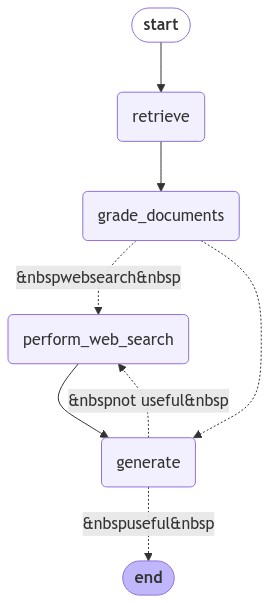

In [101]:
from IPython.display import Image, display 
display(Image(app.get_graph().draw_mermaid_png()))